In [55]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
%matplotlib inline 
import numpy as np
import urllib2
import scipy.stats as stats

np.set_printoptions(precision=3, suppress=True)
url = ('https://raw.githubusercontent.com/Upward-Spiral-Science'
       '/data/master/syn-density/output.csv')
data = urllib2.urlopen(url)
csv = np.genfromtxt(data, delimiter=",")[1:] # don't want first row (labels)

# chopping data based on thresholds on x and y coordinates
x_bounds = (409, 3529)
y_bounds = (1564, 3124)

def check_in_bounds(row, x_bounds, y_bounds):
    if row[0] < x_bounds[0] or row[0] > x_bounds[1]:
        return False
    if row[1] < y_bounds[0] or row[1] > y_bounds[1]:
        return False
    if row[3] == 0:
        return False
    
    return True

indices_in_bound, = np.where(np.apply_along_axis(check_in_bounds, 1, csv, x_bounds, y_bounds))
data_thresholded = csv[indices_in_bound]
n = data_thresholded.shape[0]


def synapses_over_unmasked(row):
    s = (row[4]/row[3])*(64**3)
    return [row[0], row[1], row[2], s]

syn_unmasked = np.apply_along_axis(synapses_over_unmasked, 1, data_thresholded)
syn_normalized = syn_unmasked

### 1) Bic keeps getting better as we go up right now--let's look at more clusters!

#### 1.1 Looking at BIC curve for more clusters

In [56]:
import sklearn.mixture as mixture

# Randomly Sample
samples = 10000
perm = np.random.permutation(xrange(1, len(syn_normalized[:])))
syn_normalized_sample = syn_normalized[perm[:samples]]
bics = []
max_clusters = 30
for i in range(1,15):
    print ("\ntest: bic loop #%d: " %(i)),
    bic = np.array([])
    i = np.array(range(1, max_clusters))
    print ("cluster loop: "),
    for idx in range(1, max_clusters):
        print ("%d, " %(idx)),
        gmm = mixture.GMM(n_components=idx, n_iter=1000, covariance_type='diag')
        gmm.fit(syn_normalized_sample)
        bic = np.append(bic, gmm.bic(syn_normalized_sample))
    bics.append(bic)
bic = np.asarray(bics)
bic_mean = np.max(bic,0)

plt.figure(figsize=(7,7))
plt.plot(i, 1.0/bic_mean)
plt.title('BIC')
plt.ylabel('score')
plt.xlabel('number of clusters')
plt.show()



test: bic loop #1:  cluster loop:  1,  2,  3,  4,  5,  6,  7, 

KeyboardInterrupt: 

#### 1.2) Compute mean, variance on each cluster

In [57]:
# From the BIC curve above, we see an elbow at 27 clusters. (Not sure what to do about the weird spike)

n_clusters = 27
gmm = mixture.GMM(n_components=n_clusters, n_iter=1000, covariance_type='diag')
clusters = [[] for i in xrange(n_clusters)]
predicted = gmm.fit_predict(syn_normalized_sample)
for label, row in zip(predicted, syn_normalized[:,]):
    clusters[label].append(row)

for i in xrange(n_clusters):
    clusters[i] = np.array(clusters[i])
    print "# of samples in cluster %d: %d" % (i+1, len(clusters[i])) 
    print "centroid: ", np.average(clusters[i], axis=0)
    print "cluster covariance: "
    covar = np.cov(clusters[i].T)
    print covar
    print "determinant of covariance matrix: ", np.linalg.det(covar)
    print

 # of samples in cluster 1: 375
centroid:  [  817.408  2347.744   599.936   299.237]
cluster covariance: 
[[  63050.151  -11956.492    2165.056    -132.121]
 [ -11956.492  220376.405    4262.607  -20305.616]
 [   2165.056    4262.607  122317.793    -666.514]
 [   -132.121  -20305.616    -666.514   12271.565]]
determinant of covariance matrix:  1.74281068913e+19

# of samples in cluster 2: 322
centroid:  [  812.929  2282.835   589.317   301.487]
cluster covariance: 
[[  64563.979   -6830.962    -803.379     985.432]
 [  -6830.962  217029.154    7928.417  -17712.872]
 [   -803.379    7928.417  121322.311    1030.076]
 [    985.432  -17712.872    1030.076   10326.677]]
determinant of covariance matrix:  1.49667118111e+19

# of samples in cluster 3: 438
centroid:  [  800.158  2360.473   598.089   305.168]
cluster covariance: 
[[  62652.023    5396.623   -4513.305   -1752.619]
 [   5396.623  204276.428    5476.647  -19176.1  ]
 [  -4513.305    5476.647  117005.985    4227.   ]
 [  -1752.619

#### 1.3) Scatter plot with 24 clusters

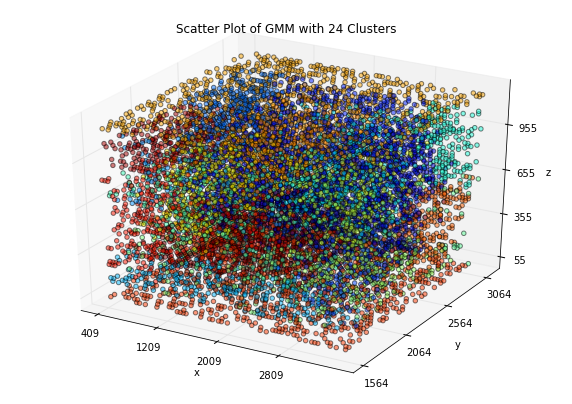

In [58]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 7))
ax = fig.gca(projection='3d')
ax.view_init()
ax.dist = 10  # distance
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_title('Scatter Plot of GMM with 24 Clusters')
ax.set_xticks(np.arange(min(syn_normalized_sample[:,0]), max(syn_normalized_sample[:,0])+1, 800))
ax.set_yticks(np.arange(min(syn_normalized_sample[:,1]), max(syn_normalized_sample[:,1])+1, 500))
ax.set_zticks(np.arange(min(syn_normalized_sample[:,2]), max(syn_normalized_sample[:,2])+1, 300))

ax.scatter(
           syn_normalized_sample[:, 0], syn_normalized_sample[:, 1], syn_normalized_sample[:, 2],  # data
           c=predicted,  # marker colour
           alpha=.5
    )

plt.show()

### 2) Looking at the "spike" from last time--PCA Analysis

Points in spike:  11465
Average Density:  0.00134070207006
Std Deviation:  8.46720771375e-05


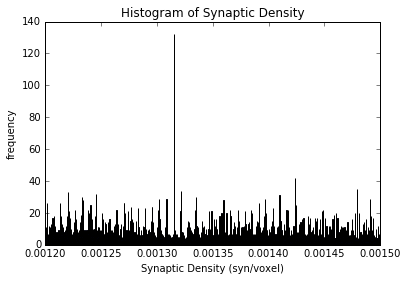

In [59]:
# Extract the spike
from mpl_toolkits.mplot3d import axes3d

a = np.apply_along_axis(lambda x:x[4]/x[3], 1, data_thresholded)

# Spike
spike = a[np.logical_and(a <= 0.0015, a >= 0.0012)]
print "Points in spike: ", len(spike)
print "Average Density: ", np.mean(spike)
print "Std Deviation: ", np.std(spike)

# Histogram
hist_n, bins, _ = plt.hist(spike, 2000)
plt.title('Histogram of Synaptic Density')
plt.xlabel('Synaptic Density (syn/voxel)')
plt.ylabel('frequency')

# Scatter plot
data_thresholded[:,4] = a
spike_coords = data_thresholded[np.logical_and(data_thresholded[:,4] <= 0.0015, data_thresholded[:,4] >= 0.0012)]

[[ 0.049 -0.476  0.467  0.743  0.   ]
 [-0.346 -0.693 -0.633 -0.023  0.   ]
 [ 0.921 -0.136 -0.357  0.077  0.   ]
 [-0.173  0.525 -0.504  0.664 -0.   ]]
[ 0.311  0.265  0.25   0.173]
(11465L, 4L)


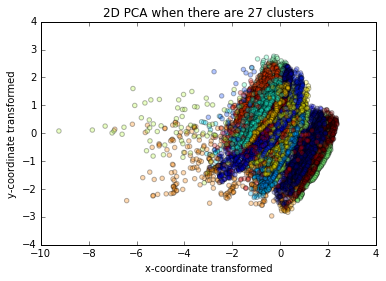

In [60]:
from sklearn.decomposition import PCA
import sklearn.mixture as mixture

# center each variable and give it unit variance for PCA

def center(row, means, std_devs):
    for idx, mean, std_dev in zip(range(4), means, std_devs):
        row[idx] -= mean
        row[idx] *= 1.0/std_dev
    return row

syn_centered = np.apply_along_axis(center, 1, spike_coords,
                                   *zip(*[(np.average(spike_coords[:, i]), 
                                   np.std(spike_coords[:, i])) for i in range(4)]))
pca = PCA(n_components = 4)
transform = pca.fit_transform(syn_centered)
print pca.components_
print pca.explained_variance_ratio_
print transform.shape

# plot the clusters along the first 2 principal components
n_clusters = 27
gmm = mixture.GMM(n_components=n_clusters, n_iter=1000, covariance_type='diag')
predicted = gmm.fit_predict(spike_coords)

plt.scatter(transform[:, 0], transform[:, 1], c=predicted, alpha=.3)
plt.title('2D PCA when there are 27 clusters')
plt.xlabel('x-coordinate transformed')
plt.ylabel('y-coordinate transformed')
plt.show()

Layer boundaries seem to be fairly well defined. Layers in along y-direction across x-direction.

### 3) Regressions on the "spike"

In [19]:
# Regression (x,y,z,syn/unmasked) on cleaned data ##################################
# Load regressions
from sklearn.linear_model import LinearRegression
from sklearn.svm import LinearSVR
from sklearn.neighbors import KNeighborsRegressor as KNN
from sklearn.ensemble import RandomForestRegressor as RF
from sklearn.preprocessing import PolynomialFeatures as PF
from sklearn.pipeline import Pipeline
from sklearn import cross_validation
names = ['Linear Regression','SVR','KNN Regression','Random Forest Regression','Polynomial Regression']
regressions = [LinearRegression(),
               LinearSVR(C=1.0),
               KNN(n_neighbors=10, algorithm='auto'),
               RF(max_depth=5, max_features=1),
               Pipeline([('poly', PF(degree=2)),('linear', LinearRegression(fit_intercept=False))])]
k_fold = 10

print('Regression on spike') # old: X=(x,y,z), Y=syn/unmasked')
X = spike_coords[:, (0,1,2)] # x,y,z
Y = spike[:] # syn/unmasked from spike
for idx2, reg in enumerate(regressions):
    scores = cross_validation.cross_val_score(reg, X, Y, scoring='r2', cv=k_fold)
    print("R^2 of %s: %0.2f (+/- %0.2f)" % (names[idx2], scores.mean(), scores.std() * 2))
    
print "regression done"



Regression on spike
R^2 of Linear Regression: 0.01 (+/- 0.07)
R^2 of SVR: -0.83 (+/- 1.13)
R^2 of KNN Regression: -0.04 (+/- 0.09)
R^2 of Random Forest Regression: -0.01 (+/- 0.04)
R^2 of Polynomial Regression: 0.03 (+/- 0.07)
regression done


In [27]:
print('Regressions on x and spike')
X = spike_coords[:, [0]] # x,y,z
Y = spike[:] # syn/unmasked from spike
for idx2, reg in enumerate(regressions):
    scores = cross_validation.cross_val_score(reg, X, Y, scoring='r2', cv=k_fold)
    print("R^2 of %s: %0.2f (+/- %0.2f)" % (names[idx2], scores.mean(), scores.std() * 2))

# y 
print
print('Regression on y and spike')
X = spike_coords[:, [1]] # x,y,z
Y = spike[:] # syn/unmasked from spike
for idx2, reg in enumerate(regressions):
    scores = cross_validation.cross_val_score(reg, X, Y, scoring='r2', cv=k_fold)
    print("R^2 of %s: %0.2f (+/- %0.2f)" % (names[idx2], scores.mean(), scores.std() * 2))

# z
print
print('Regression on z and spike')
X = spike_coords[:, [2]] # x,y,z
Y = spike[:] # syn/unmasked from spike
for idx2, reg in enumerate(regressions):
    scores = cross_validation.cross_val_score(reg, X, Y, scoring='r2', cv=k_fold)
    print("R^2 of %s: %0.2f (+/- %0.2f)" % (names[idx2], scores.mean(), scores.std() * 2))


Regressions on x and spike
R^2 of Linear Regression: -0.01 (+/- 0.04)
R^2 of SVR: -0.48 (+/- 1.65)
R^2 of KNN Regression: -0.21 (+/- 0.43)
R^2 of Random Forest Regression: -0.01 (+/- 0.04)
R^2 of Polynomial Regression: -0.01 (+/- 0.03)

Regression on y and spike
R^2 of Linear Regression: 0.01 (+/- 0.06)
R^2 of SVR: -0.81 (+/- 1.29)
R^2 of KNN Regression: -0.09 (+/- 0.09)
R^2 of Random Forest Regression: -0.01 (+/- 0.04)
R^2 of Polynomial Regression: 0.01 (+/- 0.07)

Regression on z and spike
R^2 of Linear Regression: -0.01 (+/- 0.04)
R^2 of SVR: -0.92 (+/- 1.33)
R^2 of KNN Regression: -0.09 (+/- 0.10)
R^2 of Random Forest Regression: -0.01 (+/- 0.04)
R^2 of Polynomial Regression: -0.00 (+/- 0.04)


### 4) Visualization of the "spike"

In [77]:
print "another cool visualization"

another cool visualization


### 5) Histograms from bijan